## Imports

In [155]:
import json
import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from string import punctuation
import re
from keras.utils import to_categorical
from gensim.models import KeyedVectors
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers import Bidirectional
from keras.layers import Embedding
# from keras.utils.np_utils import probas_to_classes
from sklearn import preprocessing
from keras.models import Sequential
from sklearn.metrics import confusion_matrix,f1_score,precision_score,recall_score,accuracy_score
%matplotlib inline

from matplotlib import rcParams
from random import shuffle
# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27

## loading data

In [65]:
def load_data_from_json(filename):
    with open(filename,'r') as f:
        return json.load(f)

In [66]:
master_dict = load_data_from_json('dataset/task1_post_ABSA_train.json')

In [67]:
master_dict

{'14860': {'info': [{'aspects': "['Stock/Price Action/Bullish/Bull Position']",
    'sentiment_score': '0.459',
    'snippets': "['Slowly adding some $FIO here but gotta be careful']",
    'target': 'FIO'}],
  'sentence': 'Slowly adding some $FIO here but gotta be careful. This will be one of biggest winners in 2012'},
 '14864': {'info': [{'aspects': "['Stock/Technical Analysis']",
    'sentiment_score': '0.438',
    'snippets': "['Long setup. MACD cross.']",
    'target': 'TRX'}],
  'sentence': '$TRX http://stks.co/1KkK Long setup. MACD cross.'},
 '14867': {'info': [{'aspects': "['Stock/Price Action/Bearish']",
    'sentiment_score': '-0.506',
    'snippets': "['both fundementals and charts look like poopoo this quarter.']",
    'target': 'AMZN'}],
  'sentence': 'I am not optimistic about $amzn both fundementals and charts look like poopoo this quarter.'},
 '14875': {'info': [{'aspects': "['Stock/Price Action/Bearish/Bearish behaviour']",
    'sentiment_score': '-0.202',
    'snippets

## insight into aspects 

In [68]:
def extract_data_from_dict(master_dict):
    id_sentence = []
    sentence = []
    aspect = []
    target = []
    for key in master_dict.keys():
        id_sentence.append(int(key))
        sentence.append(master_dict[key]['sentence'])
        temp_target=[]
        temp_aspect = []
        for element in master_dict[key]['info']:
            temp_target.append(element['target'])
            temp_aspect.append(eval(element['aspects']))
        target.append(temp_target)
        aspect.append(temp_aspect)
    return id_sentence,sentence,aspect,target

In [69]:
id_sentence,sentence,aspect,target = extract_data_from_dict(master_dict)

In [70]:
aspect

[[['Stock/Price Action/Bullish/Bull Position']],
 [['Stock/Technical Analysis']],
 [['Stock/Price Action/Bearish']],
 [['Stock/Price Action/Bearish/Bearish behaviour']],
 [['Stock/Technical Analysis']],
 [['Stock/Price Action/Bullish']],
 [['Stock/Price Action/Bullish/Bullish behaviour']],
 [['Stock/Price Action/Bearish']],
 [['Stock/Price Action/Bullish']],
 [['Stock/Options/Strategies']],
 [['Stock/Options/Strategies']],
 [['Stock/Price Action/Bullish']],
 [['Stock/Price Action/Bullish']],
 [['Stock/Price Action']],
 [['Stock/Price Action/Bullish/Bullish behaviour']],
 [['Stock/Price Action/Bullish']],
 [['Stock/Price Action/Bearish']],
 [['Stock/Technical Analysis']],
 [['Stock/Technical Analysis']],
 [['Stock/Price Action/Bearish']],
 [['Stock/Price Action/Bullish']],
 [['Market/Volatility']],
 [['Stock/Price Action/Volatility/Short Selling']],
 [['Stock/Price Action/Bullish/Bullish behaviour']],
 [['Stock/Technical Analysis']],
 [['Stock/Technical Analysis']],
 [['Stock/Technical 

In [71]:
#converting data into flat str
sentence_f = []
id_sentence_f = []
target_f = []
aspect_f = []
for a0 in zip(aspect,target,sentence,id_sentence):
    for a1 in zip(a0[0],a0[1]):
        for a2 in a1[0]:
            aspect_f.append(a2)
            target_f.append(a1[1])
            sentence_f.append(a0[2])
            id_sentence_f.append(a0[3])

In [72]:
len(id_sentence_f),len(sentence_f),len(target_f),len(aspect_f)

(675, 675, 675, 675)

In [73]:
aspect_f_level1= []
aspect_f_level2=[]
for asp in aspect_f:
    aspect_f_level1.append(asp.split('/')[0])
    aspect_f_level2.append(asp.split('/')[1])

In [74]:
len(aspect_f_level2),len(aspect_f_level1)

(675, 675)

In [75]:
n_label_level_1 = len(set(aspect_f_level1))
n_label_level_2 = len(set(aspect_f_level2))
n_label_level_1,n_label_level_2

(3, 21)

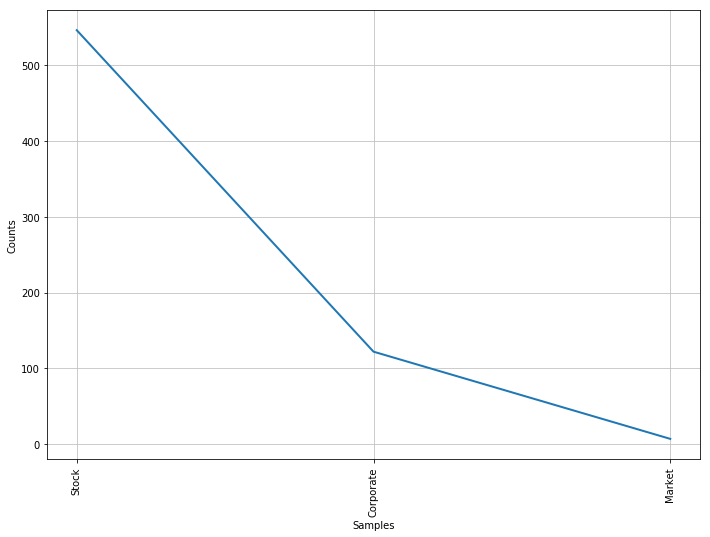

FreqDist({'Stock': 546, 'Corporate': 122, 'Market': 7})


In [76]:
level1_freq = FreqDist(aspect_f_level1)
level1_freq.plot()
level1_freq.pprint()

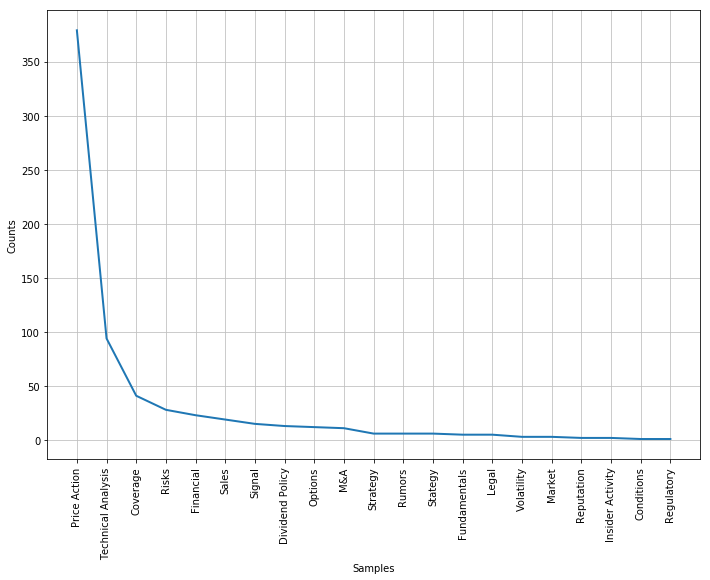

FreqDist({'Price Action': 379, 'Technical Analysis': 94, 'Coverage': 41, 'Risks': 28, 'Financial': 23, 'Sales': 19, 'Signal': 15, 'Dividend Policy': 13, 'Options': 12, 'M&A': 11, 'Strategy': 6, 'Rumors': 6, 'Stategy': 6, 'Fundamentals': 5, 'Legal': 5, 'Volatility': 3, 'Market': 3, 'Reputation': 2, 'Insider Activity': 2, 'Conditions': 1, 'Regulatory': 1})


In [77]:
level2_freq = FreqDist(aspect_f_level2)
level2_freq.plot()
level2_freq.pprint(n_label_level_2)

In [78]:
# #finding least freq classes into other
# n_of_lables_to_club = 17
# temp = [i[0] for i in level1_freq.most_common()]
# least_freq_level1 = temp[-n_of_lables_to_club:]
# least_freq_level1

In [79]:
def get_level_pairs(l1,l2):
    level_pair = dict()
    for pair in zip(l1,l2):
        if pair[1] in level_pair.keys():
            level_pair[pair[1]].append(pair[0])
        else:
            level_pair[pair[1]] = [pair[0]]
    for _ in level_pair.keys():
        level_pair[_] = list(set(level_pair[_]))
    return level_pair

In [80]:
L2_L1_pair = get_level_pairs(aspect_f_level1,aspect_f_level2)
L1_L2_pair = get_level_pairs(aspect_f_level2,aspect_f_level1)

In [81]:
L1_L2_pair

{'Corporate': ['Reputation',
  'Dividend Policy',
  'Risks',
  'Legal',
  'Financial',
  'Stategy',
  'Regulatory',
  'Technical Analysis',
  'Rumors',
  'M&A',
  'Strategy',
  'Sales'],
 'Market': ['Volatility', 'Market', 'Conditions'],
 'Stock': ['Insider Activity',
  'Price Action',
  'Options',
  'Coverage',
  'Technical Analysis',
  'Fundamentals',
  'Signal']}

In [82]:
L2_L1_pair

{'Conditions': ['Market'],
 'Coverage': ['Stock'],
 'Dividend Policy': ['Corporate'],
 'Financial': ['Corporate'],
 'Fundamentals': ['Stock'],
 'Insider Activity': ['Stock'],
 'Legal': ['Corporate'],
 'M&A': ['Corporate'],
 'Market': ['Market'],
 'Options': ['Stock'],
 'Price Action': ['Stock'],
 'Regulatory': ['Corporate'],
 'Reputation': ['Corporate'],
 'Risks': ['Corporate'],
 'Rumors': ['Corporate'],
 'Sales': ['Corporate'],
 'Signal': ['Stock'],
 'Stategy': ['Corporate'],
 'Strategy': ['Corporate'],
 'Technical Analysis': ['Corporate', 'Stock'],
 'Volatility': ['Market']}

In [83]:
C_Stock = 0
C_Corporate = 0
for pair in zip(aspect_f_level1,aspect_f_level2):
    if pair[1] == 'Technical Analysis':
        if pair[0] == 'Stock':
            C_Stock+=1
        else:
            C_Corporate+=1
print('C_Stock == ',C_Stock)
print('C_Corporate ==',C_Corporate)

C_Stock ==  92
C_Corporate == 2


## pre - processing data

In [84]:
def clean_sentence(sentence):
    #remove multiple repeat non num-aplha char !!!!!!!!!-->!
    sentence = re.sub(r'(\W)\1{2,}', r'\1', sentence) 
    #removes alpha char repeating more than twice aaaa->aa
    sentence = re.sub(r'(\w)\1{2,}', r'\1\1', sentence)
    #removes links
    sentence = re.sub(r'(?P<url>https?://[^\s]+)', r'', sentence)
    # remove @usernames
    sentence = re.sub(r"(?:\@|https?\://)\S+", "", sentence)
    #removing stock names to see if it helps
    sentence = re.sub(r"(?:\$|https?\://)\S+", "", sentence)
    #remove # from #tags
    sentence = sentence.replace('#','')
    # split into tokens by white space
    tokens = sentence.split()
    # remove punctuation from each token
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
#     tokens = [word for word in tokens if word.isalpha()]
#no removing non alpha words to keep stock names($ZSL)
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    tokens = ' '.join(tokens)
    return tokens

In [85]:
sentenceX = [clean_sentence(x) for x in sentence_f]

In [87]:
sentenceX

['Slowly adding gotta careful This one biggest winners 2012',
 'Long setup MACD cross',
 'optimistic fundementals charts look like poopoo quarter',
 'might selling ahead earnings',
 'Looks good weekly chart',
 'back trendline 104',
 'RT close looking good bulls Will hold positions see close Keep buying',
 'Profit taking morning That pressure stock Im still bullish',
 'turning Coming far could go far Stock price implies pay nothing business',
 'looking good Calls active month weekly',
 'Sold 45 hedging 45 Letting calls ride solo',
 'Long setup Closed 20MA MACD cross November catalyst',
 'close 2864 ready rock roll',
 'Im liking price action currently target 2400 year end',
 'closng higher',
 'RS Sweet want break new 52week The earnings growth justifies way higher',
 'bull move ended waiting next setup',
 'Double bottom handle buy point 2951',
 'Daily chart though RSI Stoch point possible move theres lot resistance',
 'Downside breakout looks coming soon',
 'getting readyTarget plus clos

In [88]:
Level_1Y = aspect_f_level1
Level_2Y = aspect_f_level2

In [89]:
# #clubing least n freq Level 1class together into Other
# Level_1_lables_clubed = list()
# for aspect in Level_1_lables:
#     if aspect in least_freq_level1:
#         Level_1_lables_clubed.append('Other')
#     else:
#         Level_1_lables_clubed.append(aspect)
# len(Level_1_lables_clubed),len(Level_1_lables)

In [90]:
# level1_clubed_freq = FreqDist(Level_1_lables_clubed)
# level1_clubed_freq.plot(10)
# level1_clubed_freq.pprint()

In [91]:
lengths = [len(s.split()) for s in sentenceX]

max len =  21


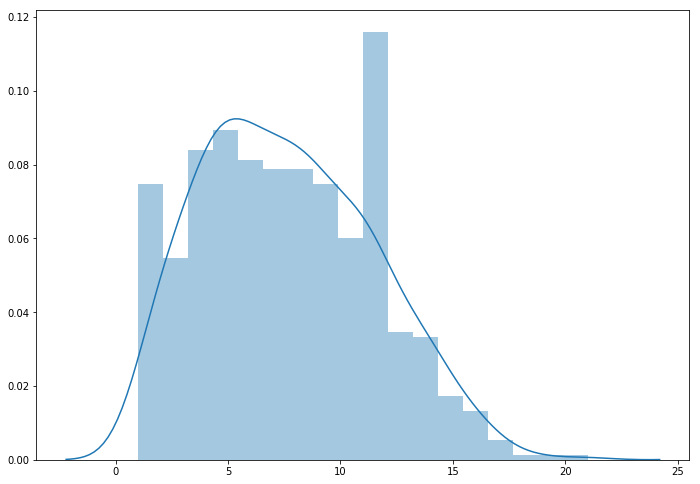

In [92]:
print('max len = ',max(lengths))
sns.distplot(lengths)

In [93]:
max_length  = 15

##  Model

In [94]:
tranLines = sentenceX
trainLabels = aspect_f_level2

In [95]:
no_of_classes = n_label_level_2
no_of_classes

21

In [96]:
trainX,testX = tranLines[:int(len(tranLines)*0.9)],tranLines[int(len(tranLines)*0.9):]
trainY,testY = trainLabels[:int(len(trainLabels)*0.9)],trainLabels[int(len(trainLabels)*0.9):]

In [97]:
print(len(trainX),len(trainY))
print(len(testX),len(testY))

607 607
68 68


In [98]:
# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [99]:
# encode a list of lines
def encode_text(tokenizer, lines, length):
    # integer encode
    encoded = tokenizer.texts_to_sequences(lines)
    # pad encoded sequences
    padded = pad_sequences(encoded, maxlen=length, padding='post')
    return padded

In [100]:
# create tokenizer
tokenizer = create_tokenizer(trainX)
# calculate max document length
# calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Max document length: %d' % max_length)
print('Vocabulary size: %d' % vocab_size)
# encode data
trainX = encode_text(tokenizer, trainX, max_length)
testX = encode_text(tokenizer, testX, max_length)
print(trainX.shape,testX.shape)

Max document length: 15
Vocabulary size: 2043
(607, 15) (68, 15)


In [101]:
# trainY

In [102]:
def convert_lables(trainY,testY):
    le = preprocessing.LabelEncoder()
    le.fit(trainY)
#     print(le.classes_)
    temp1 = le.transform(trainY)
    temp2 = le.transform(testY)
    return to_categorical(temp1,no_of_classes),to_categorical(temp2,no_of_classes),le.classes_

In [103]:
trainY,testY,lable_encoding = convert_lables(trainY,testY)

In [104]:
len(testY)

68

In [105]:
#loading Google Word2Vec
def load_google_word2vec(file_name):
    return KeyedVectors.load_word2vec_format(file_name, binary=True)

In [106]:
def get_word2vec_embedding_matrix(model):
    embedding_matrix = np.zeros((vocab_size,300))
    for word, i in tokenizer.word_index.items():
        try:
            embedding_vector = model[word]
        except KeyError:
            embedding_vector = None
        if embedding_vector is not None:
            embedding_matrix[i]=embedding_vector
    return embedding_matrix

In [107]:
word2vec_model= load_google_word2vec('word_embeddings/GoogleNews-vectors-negative300.bin')
embedding_matrix_word2vec = get_word2vec_embedding_matrix(word2vec_model)

In [117]:
def defina_model():



    lstm_out = 400
    model = Sequential()
    model.add(Embedding(vocab_size,300,weights=[embedding_matrix_word2vec],input_length=max_length,trainable = False))
    model.add(Bidirectional(LSTM(lstm_out, recurrent_dropout=0.2)))
    model.add(Dense(400,activation='relu'))
    model.add(Dense(200,activation='relu'))
    model.add(Dense(no_of_classes,activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
    print(model.summary())
    return model

In [120]:
model = defina_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 15, 300)           612900    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 800)               2243200   
_________________________________________________________________
dense_9 (Dense)              (None, 400)               320400    
_________________________________________________________________
dense_10 (Dense)             (None, 200)               80200     
_________________________________________________________________
dense_11 (Dense)             (None, 21)                4221      
Total params: 3,260,921
Trainable params: 2,648,021
Non-trainable params: 612,900
_________________________________________________________________
None


In [121]:
history_object = model.fit(trainX, trainY, epochs=20,batch_size=16)

Epoch 1/20
607/607 [==============================] - 8s 13ms/step - loss: 1.8264 - acc: 0.5700
Epoch 2/20
607/607 [==============================] - 7s 11ms/step - loss: 1.2336 - acc: 0.6606
Epoch 3/20
607/607 [==============================] - 7s 11ms/step - loss: 0.9084 - acc: 0.7199
Epoch 4/20
607/607 [==============================] - 7s 11ms/step - loss: 0.6873 - acc: 0.7809
Epoch 5/20
607/607 [==============================] - 8s 13ms/step - loss: 0.5268 - acc: 0.8369
Epoch 6/20
607/607 [==============================] - 7s 12ms/step - loss: 0.3626 - acc: 0.8896
Epoch 7/20
607/607 [==============================] - 8s 12ms/step - loss: 0.2903 - acc: 0.9193
Epoch 8/20
607/607 [==============================] - 9s 14ms/step - loss: 0.1458 - acc: 0.9588
Epoch 9/20
607/607 [==============================] - 7s 12ms/step - loss: 0.1177 - acc: 0.9588
Epoch 10/20
607/607 [==============================] - 7s 12ms/step - loss: 0.1183 - acc: 0.9687
Epoch 11/20
607/607 [==================

In [122]:
model.evaluate(testX,testY)

68/68 [==============================] - 1s 12ms/step


[2.0572125210481533, 0.7647058823529411]

In [649]:
# model.evaluate(trainX,trainY)

In [124]:
pred = model.predict(testX)

In [126]:
testY

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [127]:
test_label_act = [lable_encoding[x.argmax()] for x in testY]
test_label_pred = [lable_encoding[x.argmax()] for x in pred]

In [150]:
cnf_matrix = confusion_matrix(test_label_act, test_label_pred)
cnf_matrix

array([[ 9,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  2,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1, 30,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  2,  5,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  0,  0,  2,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  3,  0,  0,  0,  1,  0,  0,  2]])

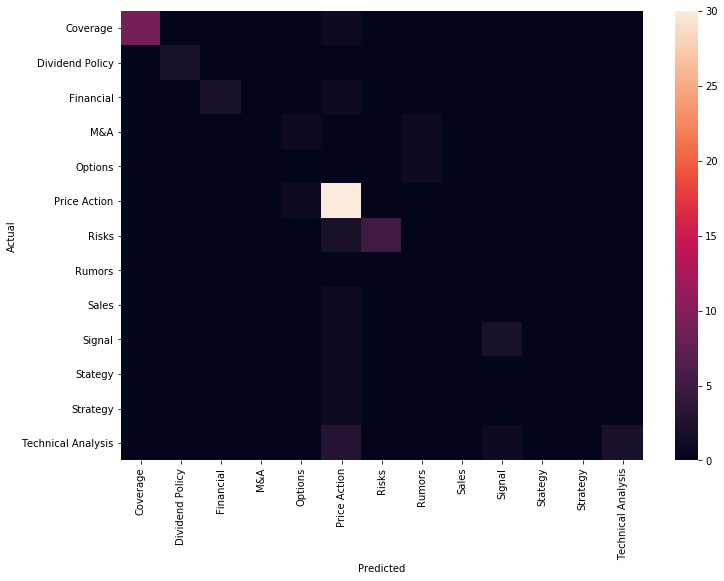

In [154]:
ConfusionMatrix(test_label_act, test_label_pred).plot(backend='seaborn')

In [168]:
#get metric scores
def print_metric(yacc,ypred,avg_type):
    print('---------------------avg type = {0}---------------------------------------------'.format(avg_type))
    print('F1 score == ', f1_score(yacc,ypred,average=avg_type))
    print('precision score == ', precision_score(yacc,ypred,average=avg_type))
    print('recall score == ', recall_score(yacc,ypred,average=avg_type))
    print('accuracy score == ', accuracy_score(yacc,ypred))

In [169]:
# print_metric(test_label_act,test_label_pred,'micro')
print_metric(test_label_act,test_label_pred,'macro')
print_metric(test_label_act,test_label_pred,'weighted')

---------------------avg type = macro---------------------------------------------
F1 score ==  0.42928475033738195
precision score ==  0.49218261413383363
recall score ==  0.40374571664894243
accuracy score ==  0.7647058823529411
---------------------avg type = weighted---------------------------------------------
F1 score ==  0.7432404540763674
precision score ==  0.7747489239598279
recall score ==  0.7647058823529411
accuracy score ==  0.7647058823529411


/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [470]:
# act_level1 = Level_1_lables_clubed[int(len(trainLabels)*0.9):]
# act_level0 = Level_0_lables[int(len(trainLabels)*0.9):]
# act_aspect= list()
# for aspect in zip(act_level0,act_level1):
#     act_aspect.append(aspect[0]+'/'+aspect[1])

In [469]:
# pred_level1_aspect = []
# for i in pred:
#     pred_level1_aspect.append(lable_encoding[i.argmax()])
# # for i in zip(pred_aspect,act_aspect):
#     if i[0]==i[1]:
#         count+=1
#     else:
#         print(i)
# print(count/len(act_aspect))

In [468]:
# l1_l0_clubed = get_level_pairs(Level_0_lables,Level_1_lables_clubed)
# l1_l0_clubed